In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23')

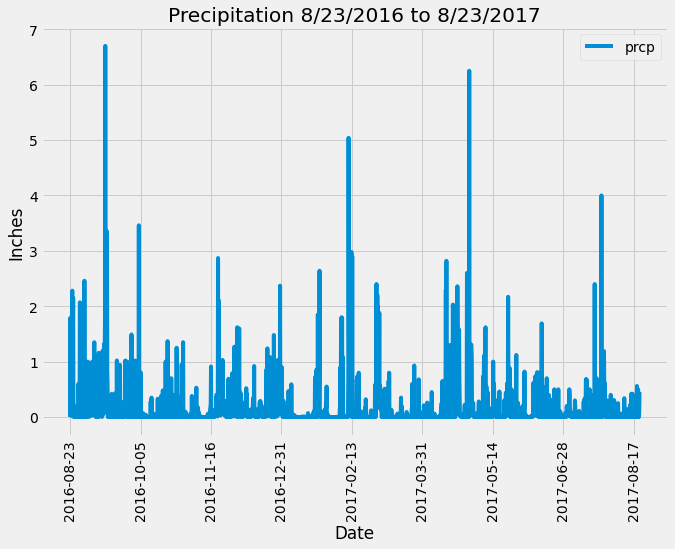

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
#query_date = dt.date(2017,8,23) - dt.timedelta(days=365)
query_date = dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d').date() - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip).set_index("date")
# precip_df["date"] = pd.to_datetime(precip_df["date"])
# precip_df.set_index("date", inplace=True)

# Sort the dataframe by date
precip_sorted = precip_df.sort_values("date").dropna()

# fig, ax = plt.subplots()

# plt.bar(precip_sorted.index, precip_sorted["prcp"])
# ticklabels = ['']*len(precip_sorted.index)
# ticklabels[::40] = [item for item in precip_sorted.index[::40]]
# ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
# fig.autofmt_xdate()

precip_sorted.plot(figsize=(10,7), x_compat=True, rot=90, legend=True)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title("Precipitation 8/23/2016 to 8/23/2017")
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_sorted.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Measurement).group_by(Measurement.station).count()
station_count

9

In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]
# most_active_station
active_station_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
    .filter(Measurement.station == most_active_station).all()
print(f"Most Active Station ID: {most_active_station}")
print(f"Min Temp: {active_station_temps[0][0]}")
print(f"Max Temp: {active_station_temps[0][1]}")
print(f"Avg Temp: {round(active_station_temps[0][2], 1)}")

Most Active Station ID: USC00519281
Min Temp: 54.0
Max Temp: 85.0
Avg Temp: 71.7


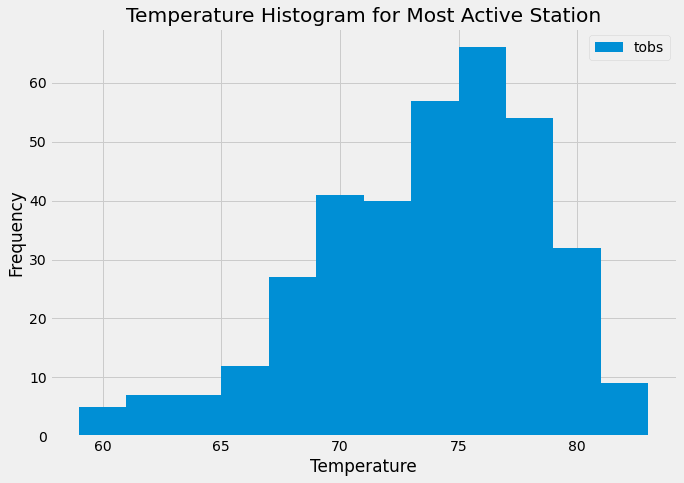

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# find the last date of the most active station
last_date = session.query(Measurement.date)\
    .filter(Measurement.station == most_active_station)\
    .order_by(Measurement.date.desc()).first()

# set a query date to gather one year of data
query_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d').date() - dt.timedelta(days=365)

# query measurement data to gather one year of temp data from most active station
temps = session.query(Measurement.tobs)\
    .filter(Measurement.date >= query_date)\
    .filter(Measurement.station == most_active_station).all()

# place data in a dataframe
temps_df = pd.DataFrame(temps)

# plot histogram of temperature data
temps_df.hist(bins=12, figsize=(10,7))
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(temps_df, loc='best')
plt.title("Temperature Histogram for Most Active Station")
plt.show()

# Close session

In [16]:
# Close Session
session.close()